<a href="https://colab.research.google.com/github/sadiareem/icece_LCC/blob/main/90_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
from collections import defaultdict
import pandas as pd
import PIL
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Paths
dataset_path = '/content/drive/MyDrive/Datasets/lungCT'
data_dir = Path(dataset_path)

# Function to count images in each class
def count_images(data_dir):
    class_counts = defaultdict(int)
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            num_images = len(list(class_dir.glob('*')))
            class_counts[class_name] = num_images
    return class_counts

# Function to extract image information
def get_image_info(data_dir):
    image_info = []
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob('*'):
                img = PIL.Image.open(img_path)
                image_info.append({
                    "Filename": img_path.name,
                    "Class": class_dir.name,
                    "Format": img.format,
                    "Size": img.size,
                    "Mode": img.mode
                })
    return pd.DataFrame(image_info)

# Function to summarize image dimensions
def summarize_image_info(image_info_df):
    print("\nImage Dimension Statistics:")
    print(f"Min width: {image_info_df['Size'].apply(lambda x: x[0]).min()}")
    print(f"Max width: {image_info_df['Size'].apply(lambda x: x[0]).max()}")
    print(f"Min height: {image_info_df['Size'].apply(lambda x: x[1]).min()}")
    print(f"Max height: {image_info_df['Size'].apply(lambda x: x[1]).max()}")
    print(f"Average width: {image_info_df['Size'].apply(lambda x: x[0]).mean()}")
    print(f"Average height: {image_info_df['Size'].apply(lambda x: x[1]).mean()}")

# Function to visualize sample images from each class
def visualize_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_dir = data_dir / class_name
        sample_images = list(class_dir.glob('*'))[:num_samples]
        for j, img_path in enumerate(sample_images):
            img = PIL.Image.open(img_path)
            ax = plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to check for corrupted images
def check_for_corrupted_images(data_dir):
    corrupted_images = []
    for class_dir in data_dir.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob('*'):
                try:
                    img = PIL.Image.open(img_path)
                    img.verify()  # Verify if the image can be opened
                except (IOError, SyntaxError) as e:
                    corrupted_images.append(img_path)
    return corrupted_images

# Function to generate a summary report
def generate_summary_report(data_dir, class_counts, image_info_df):
    print("\nDataset Summary Report")
    print("=" * 30)
    print(f"Total number of classes: {len(class_counts)}")
    print(f"Total number of images: {sum(class_counts.values())}")
    print("\nImages per class:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    summarize_image_info(image_info_df)

    corrupted_images = check_for_corrupted_images(data_dir)
    if corrupted_images:
        print("\nCorrupted images detected:")
        for img_path in corrupted_images:
            print(f"- {img_path}")
    else:
        print("\nNo corrupted images detected.")

# Extract and display dataset information
class_counts = count_images(data_dir)
image_info_df = get_image_info(data_dir)
generate_summary_report(data_dir, class_counts, image_info_df)

# Image Data Generators for loading and augmenting data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2  # Using 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Define input shape
input_shape = (180, 180, 3)

# Load the DenseNet121 base model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the first half of the layers
num_layers = len(base_model.layers)
for layer in base_model.layers[:num_layers // 2]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.15)(x)
x = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()



Mounted at /content/drive

Dataset Summary Report
Total number of classes: 4
Total number of images: 1000

Images per class:
adenocarcinoma: 338 images
squamouscellcarcinoma: 260 images
largecellcarcinoma: 187 images
normal: 215 images

Image Dimension Statistics:
Min width: 168
Max width: 1200
Min height: 110
Max height: 874
Average width: 431.383
Average height: 323.639

No corrupted images detected.
Found 801 images belonging to 4 classes.
Found 199 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 186, 186, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 45, 45, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 45, 45, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 45, 45, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,169,732 (27.35 MB)

 Trainable params: 4,763,844 (18.17 MB)

 Non-trainable params: 2,405,888 (9.18 MB)

In [ ]:
# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    callbacks=[early_stopping])


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 214s 6s/step - accuracy: 0.4106 - loss: 1.4187 - val_accuracy: 0.2161 - val_loss: 8.3141
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.5925 - loss: 0.8812 - val_accuracy: 0.2362 - val_loss: 4.1828
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.6677 - loss: 0.7853 - val_accuracy: 0.2613 - val_loss: 2.2112
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 0.6799 - loss: 0.7157 - val_accuracy: 0.4573 - val_loss: 1.1449
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.7362 - loss: 0.6641 - val_accuracy: 0.6482 - val_loss: 0.8459
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 179s 7s/step - accuracy: 0.7606 - loss: 0.5478 - val_accuracy: 0.7136 - val_loss: 0.7023
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 181s 6s/step - accuracy: 0.7845 - loss: 0.5466 - val_accuracy: 0.7487 - val_loss: 0.6351
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.7926 - loss: 0.4879 - val_accuracy: 0.7236 - val_loss: 0.

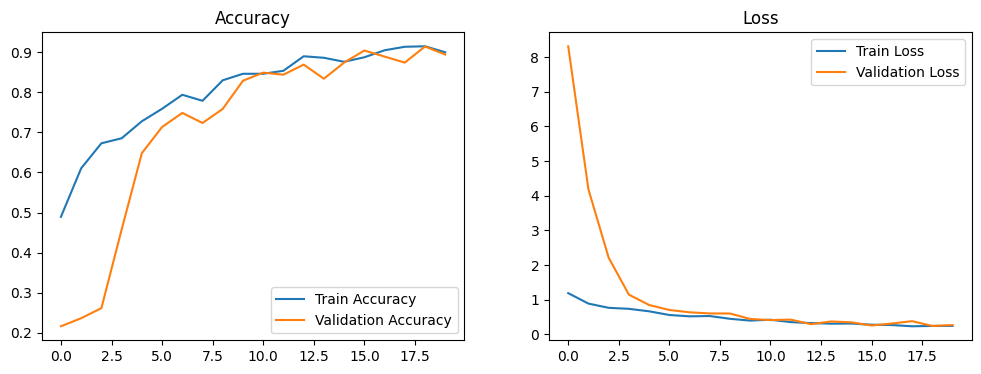

7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step


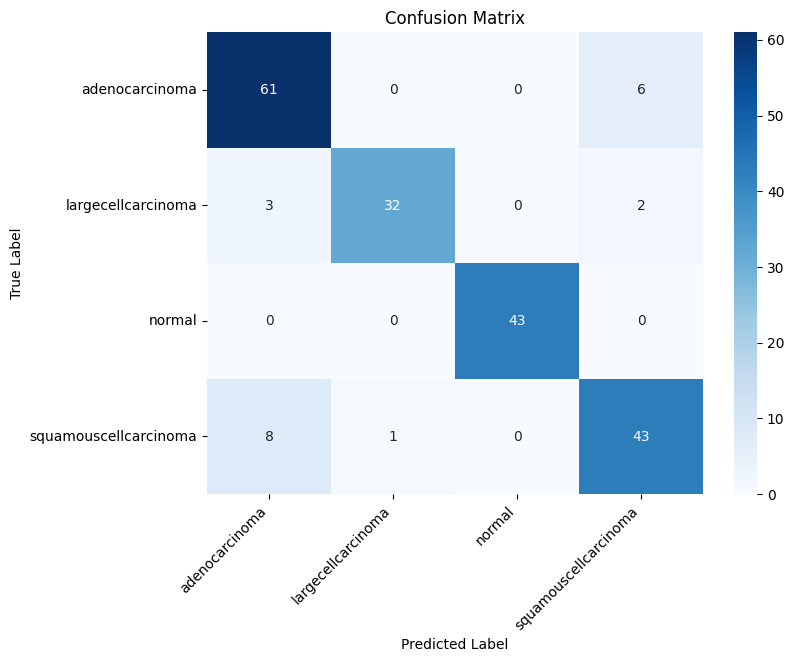

                       precision    recall  f1-score   support

       adenocarcinoma       0.85      0.91      0.88        67
   largecellcarcinoma       0.97      0.86      0.91        37
               normal       1.00      1.00      1.00        43
squamouscellcarcinoma       0.84      0.83      0.83        52

             accuracy                           0.90       199
            macro avg       0.92      0.90      0.91       199
         weighted avg       0.90      0.90      0.90       199



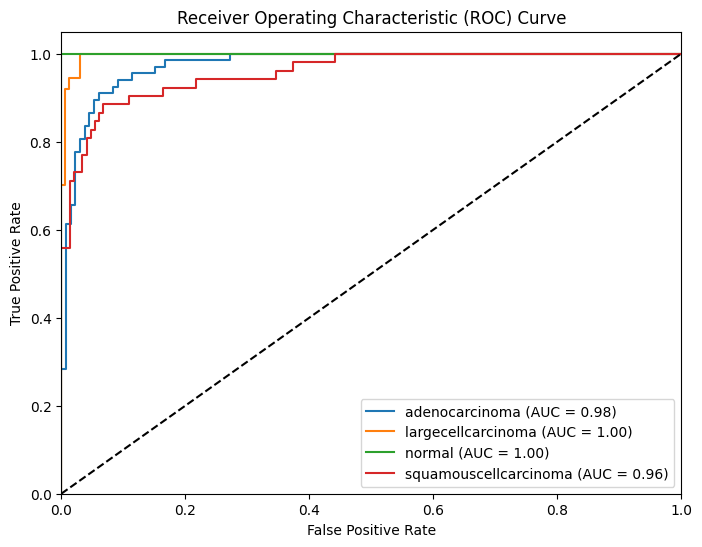

In [ ]:

# Plot Accuracy and Loss graphs
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

steps = validation_generator.samples // validation_generator.batch_size
y_pred_probs = model.predict(validation_generator, steps=steps + 1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes

# Calculate confusion matrix using class predictions, not probabilities
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_names = list(validation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Rotate labels on the x-axis
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize dictionaries for storing FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Define class labels
class_labels = ['adenocarcinoma', 'largecellcarcinoma', 'normal', 'squamouscellcarcinoma']

# Compute ROC curve and ROC area for each class
for i in range(4):  # Assuming 4 classes
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])  # Use probabilities, not class labels
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:

# Custom function for predicting new images
def predict_new_image(model, image_path, class_names, target_size=(180, 180)):
    # Load the image and preprocess it
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale image

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence_score = np.max(predictions)

    # Print the result
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence score: {confidence_score:.2f}")

# Example usage of predict_new_image function
new_image_path = '/content/drive/MyDrive/Datasets/testing/predict.jpg'
predict_new_image(model, new_image_path, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: squamouscellcarcinoma
Confidence score: 0.87
